# Amount of taxi orders prediction

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Preparation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

plt.style.use('seaborn')

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.index.is_monotonic

True

In [6]:
# check for duplicates
data.index.duplicated().sum()

0

In [7]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
# resampling - sum for each hour
data = data.resample('1H').sum()

## Analysis

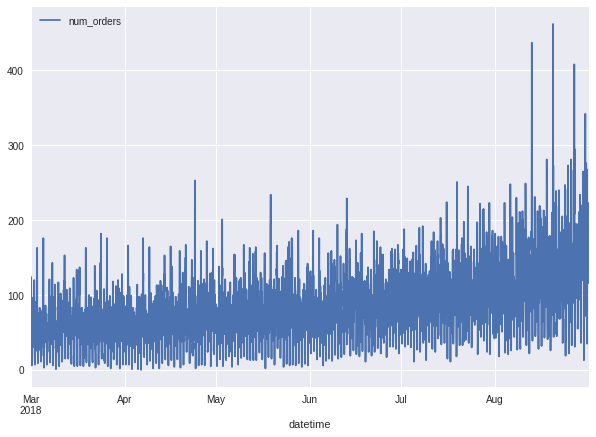

In [9]:
# distibution of orders over time
data.plot(figsize = (10,7));

In [10]:
mean = data['num_orders'].rolling(24).mean()
std = data['num_orders'].rolling(24).std()

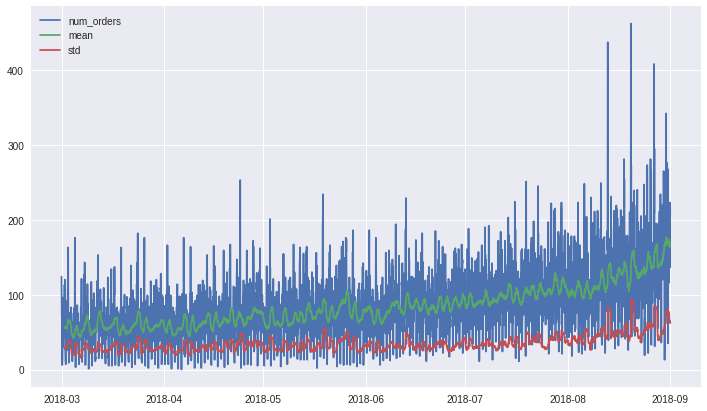

In [11]:
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
ax1.plot(data['num_orders'])
ax1.plot(mean)
ax1.plot(std)
plt.legend(['num_orders', 'mean', 'std']);

The rolling mean and rolling standard deviation increase with time. Therefore, we can conclude that the time series is not stationary.

In [12]:
decomposed = seasonal_decompose(data)

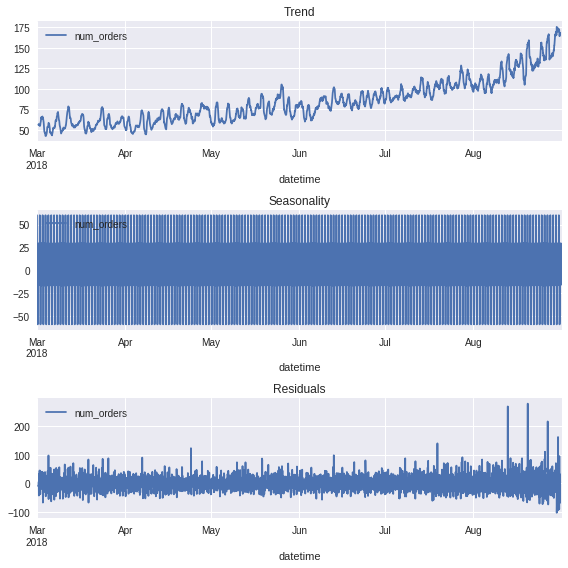

In [13]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()    # this helps fit subplots into the area

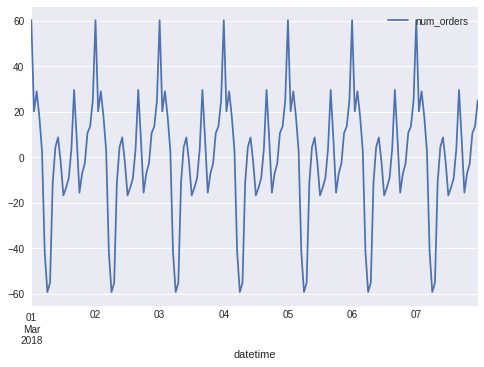

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-7'].plot();

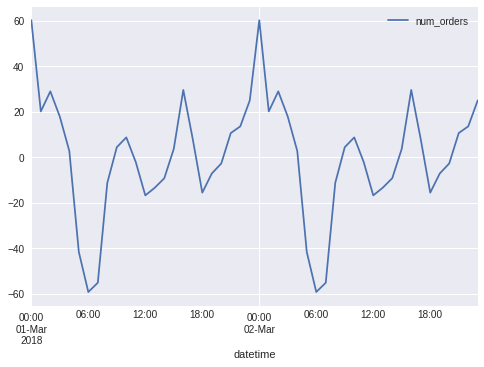

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot();

We see that our data is not stationary (it has a growing trend) and have a daily seasonality. In terms of seasonality, the lowest point is around 6:00 in the morning and the highest point is around midnight. The residuals are flactuating around 0 which is good.

## Training and testing

In [16]:
# split the data to training set and test set
train, test = tts(data, shuffle=False, test_size=0.1)

In [17]:
train.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Previous observation for a sanity check**

In [18]:
pred_test = test.shift()
pred_test.iloc[0] = train.iloc[-1]

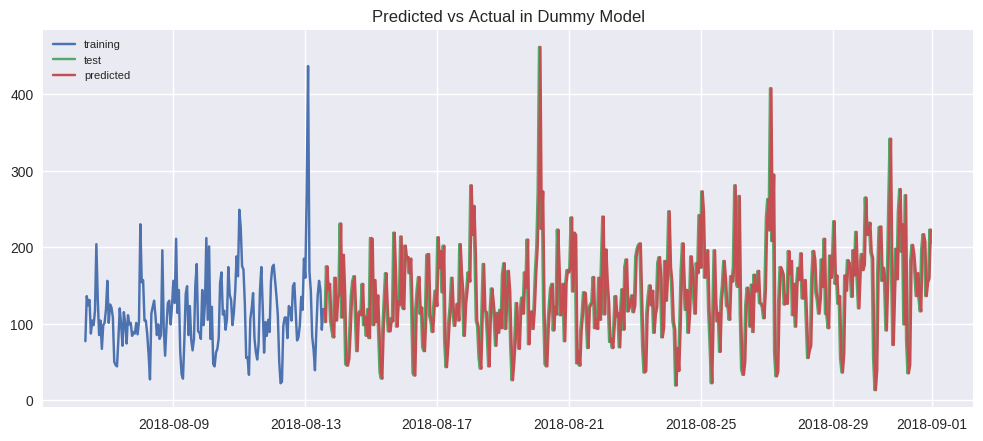

In [19]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[3800:], label='training')
plt.plot(test, label='test')
plt.plot(pred_test, label='predicted')
plt.title('Predicted vs Actual in Dummy Model')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
print('RMSE on test:', np.sqrt(mean_squared_error(test, pred_test)))

RMSE on test: 58.856486242815066


**Linear Regression**

In [21]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [22]:
# split the data to training set and test set
train, test = tts(data, shuffle=False, test_size=0.1)

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [24]:
ts_cv = TimeSeriesSplit(n_splits=4)
for i in range(4, 50, 4):
    train_cv = train.copy()
    make_features(train_cv, i, i)
    train_cv.dropna(inplace=True)
    train_X = train_cv.drop('num_orders', axis=1)
    train_y = train_cv['num_orders']
    
    model = LinearRegression()
    param_grid = {}
    grid1 = GridSearchCV(model, param_grid, cv=ts_cv, scoring = 'neg_root_mean_squared_error')

    grid1.fit(train_X, train_y)

    print(f"i = {i}, RMSE for LinearRegression model = {abs(grid1.best_score_):.3f}")

i = 4, RMSE for LinearRegression model = 31.742
i = 8, RMSE for LinearRegression model = 31.940
i = 12, RMSE for LinearRegression model = 31.717
i = 16, RMSE for LinearRegression model = 31.599
i = 20, RMSE for LinearRegression model = 31.240
i = 24, RMSE for LinearRegression model = 27.179
i = 28, RMSE for LinearRegression model = 26.822
i = 32, RMSE for LinearRegression model = 26.840
i = 36, RMSE for LinearRegression model = 26.878
i = 40, RMSE for LinearRegression model = 26.891
i = 44, RMSE for LinearRegression model = 26.915
i = 48, RMSE for LinearRegression model = 24.931


In [25]:
train_lr = train.copy()
test_lr = test.copy()
make_features(train_lr, 48, 48)
make_features(test_lr, 48, 48)
train_lr.dropna(inplace=True)
test_lr.dropna(inplace=True)
train_X = train_lr.drop('num_orders', axis=1)
train_y = train_lr['num_orders']
test_X = test_lr.drop('num_orders', axis=1)
test_y = test_lr['num_orders']

In [26]:
model = LinearRegression()
model.fit(train_X, train_y)
pred_test = model.predict(test_X)

In [27]:
pred_test = pd.Series(pred_test, index=test[-pred_test.shape[0]:].index)

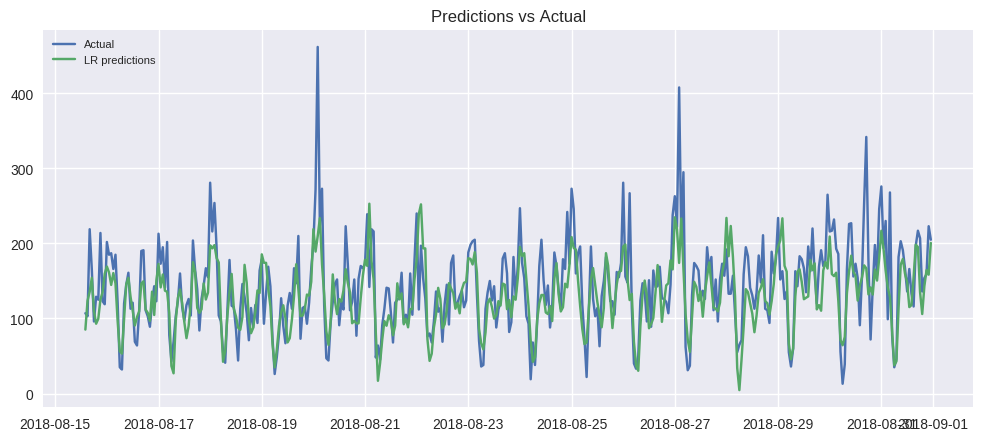

In [28]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_y, label='Actual')
plt.plot(pred_test, label='LR predictions')
plt.title('Predictions vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
print(f"RMSE on test: {np.sqrt(mean_squared_error(test_y, pred_test)):.3f}")

RMSE on test: 43.383


**Random Forest**

In [30]:
for i in range(4, 50, 4):
    train_cv = train.copy()
    make_features(train_cv, i, i)
    train_cv.dropna(inplace=True)
    train_X = train_cv.drop('num_orders', axis=1)
    train_y = train_cv['num_orders']
    
    model = RandomForestRegressor(random_state = 123)
    param_grid = {
    "n_estimators" : [20, 50, 100],
    "max_depth" : [10, 20],
}
    grid2 = GridSearchCV(model, param_grid, cv=ts_cv, scoring = 'neg_root_mean_squared_error')
    grid2.fit(train_X, train_y)
    
    print(f"i = {i}\nBest params:")
    print(grid2.best_params_)
    
    print(f"RMSE for RandomForest model = {abs(grid2.best_score_):.3f}\n")

i = 4
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.474

i = 8
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.081

i = 12
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 25.733

i = 16
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 25.822

i = 20
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.238

i = 24
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 25.909

i = 28
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.138

i = 32
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.145

i = 36
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.220

i = 40
Best params:
{'max_depth': 20, 'n_estimators': 100}
RMSE for RandomForest model = 26.175

i = 44
Best params:
{'max_depth'

In [31]:
train_rf = train.copy()
test_rf = test.copy()
make_features(train_rf, 48, 48)
make_features(test_rf, 48, 48)
train_rf.dropna(inplace=True)
test_rf.dropna(inplace=True)
train_X = train_rf.drop('num_orders', axis=1)
train_y = train_rf['num_orders']
test_X = test_rf.drop('num_orders', axis=1)
test_y = test_rf['num_orders']

In [32]:
model = RandomForestRegressor(random_state = 123, max_depth = 20, n_estimators = 100)
model.fit(train_X, train_y)
pred_test = model.predict(test_X)

In [33]:
pred_test = pd.Series(pred_test, index=test[-pred_test.shape[0]:].index)

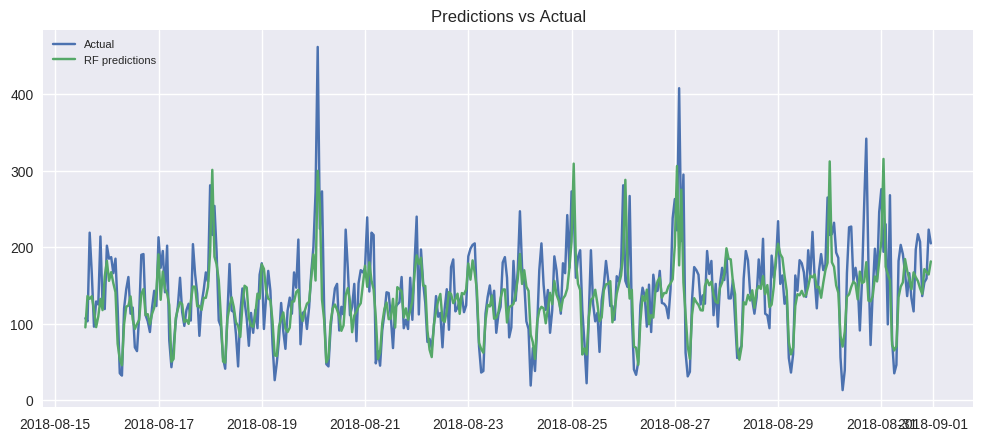

In [34]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_y, label='Actual')
plt.plot(pred_test, label='RF predictions')
plt.title('Predictions vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
print(f"RMSE on test: {np.sqrt(mean_squared_error(test_y, pred_test)):.3f}")

RMSE on test: 42.920


**LGBM Regressor**

In [36]:
for i in range(4, 50, 4):
    train_cv = train.copy()
    make_features(train_cv, i, i)
    train_cv.dropna(inplace=True)
    train_X = train_cv.drop('num_orders', axis=1)
    train_y = train_cv['num_orders']
    
    model = LGBMRegressor(random_state = 123)
    param_grid = {
        "learning_rate" : [0.1, 0.2],
        "n_estimators" : [100, 150],
        "max_depth" : [10, 20]
}
    grid3 = GridSearchCV(model, param_grid, cv=ts_cv, scoring = 'neg_root_mean_squared_error')
    grid3.fit(train_X, train_y)
    
    print(f"i = {i}\nBest params:")
    print(grid3.best_params_)
    
    print(f"RMSE for LGBM Regression model = {abs(grid3.best_score_):.3f}\n")

i = 4
Best params:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE for LGBM Regression model = 26.391

i = 8
Best params:
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
RMSE for LGBM Regression model = 25.841

i = 12
Best params:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE for LGBM Regression model = 25.470

i = 16
Best params:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE for LGBM Regression model = 25.502

i = 20
Best params:
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
RMSE for LGBM Regression model = 25.609

i = 24
Best params:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE for LGBM Regression model = 25.904

i = 28
Best params:
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100}
RMSE for LGBM Regression model = 26.037

i = 32
Best params:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE for LGBM Regression model = 26.109

i = 36
Best params:
{'lear

In [37]:
train_lgbm = train.copy()
test_lgbm = test.copy()
make_features(train_lgbm, 48, 48)
make_features(test_lgbm, 48, 48)
train_lgbm.dropna(inplace=True)
test_lgbm.dropna(inplace=True)
train_X = train_lgbm.drop('num_orders', axis=1)
train_y = train_lgbm['num_orders']
test_X = test_lgbm.drop('num_orders', axis=1)
test_y = test_lgbm['num_orders']

In [38]:
model = LGBMRegressor(random_state = 123, learning_rate=0.1, max_depth=20, n_estimators=100)
model.fit(train_X, train_y)
pred_test = model.predict(test_X)

In [39]:
pred_test = pd.Series(pred_test, index=test[-pred_test.shape[0]:].index)

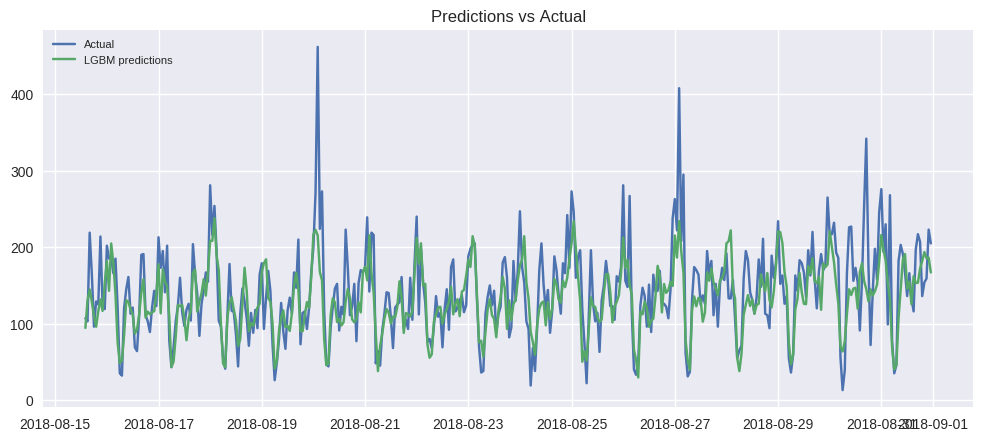

In [40]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_y, label='Actual')
plt.plot(pred_test, label='LGBM predictions')
plt.title('Predictions vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
print(f"RMSE on test: {np.sqrt(mean_squared_error(test_y, pred_test)):.3f}")

RMSE on test: 41.137


## Predicting the next hour

The best model (with the lowest RMSE score) was the LGBM Regressor. We will predict with it the next hour number of orders.

In [42]:
test = test.append(test.iloc[-1])

In [43]:
test.set_index(pd.date_range(test.index[0], periods = len(test),freq = 'H'), inplace = True)

In [44]:
test.index[-1]

Timestamp('2018-09-01 00:00:00', freq='H')

In [45]:
test.month[-1] = test.index[-1].month
test.day[-1] = test.index[-1].day
test.dayofweek[-1] = test.index[-1].dayofweek
test.hour[-1] = test.index[-1].hour

In [46]:
make_features(test, 48, 48)
test.dropna(inplace=True)
test_X = test.drop('num_orders', axis=1)

In [50]:
forecast = model.predict(np.array(test_X.iloc[-1]).reshape(1, -1))

In [64]:
idx = pd.date_range('2018-09-01 00:00:00', periods = 1, freq = 'H')
forecast = pd.Series(forecast, index = idx)

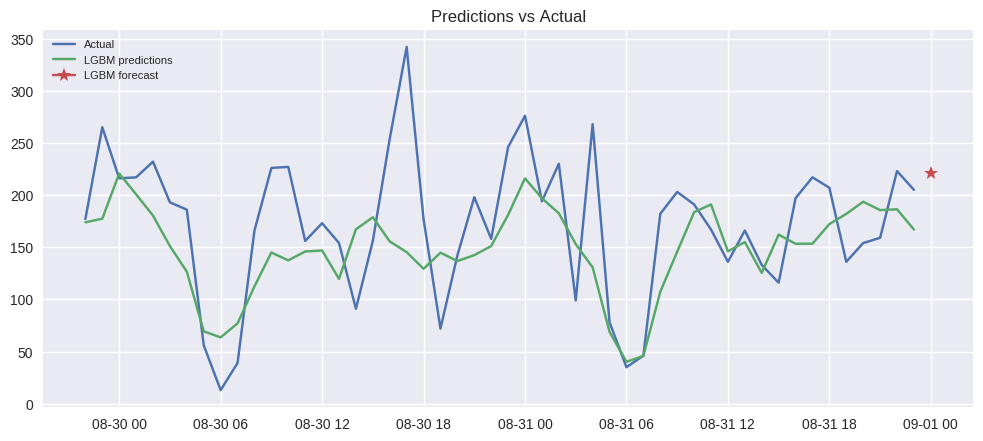

In [75]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_y[-50:], label='Actual')
plt.plot(pred_test[-50:], label='LGBM predictions')
plt.plot(forecast.index, forecast[0], marker="*", markersize=10, label='LGBM forecast')
plt.title('Predictions vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [79]:
print(f"The forecast for the next hour is: {int(forecast[0])} orders")

The forecast for the next hour is: 221 orders


## Conclusions

The aim of this project was to be able to predict the amount of orders for the next hour. We worked with historical data that was collected between 2018-03-01 to 2018-08-31 with records for every 10 minutes. For the ease of use we resampled the data for one hour intervals. We noticed that the data has a daily seasonality and in general it is stationary but has a slightly increasing trend towards the summer (it has an upward trend that generally makes it non-stationary).

Two models and a sanity model were tested. Indeed in general there is a significant difference in rmse between sanity model and the other two models which indicates that these models will be better than sanity model.